# I. 데이터 살펴보기

### 1. 데이터 준비

In [1]:
import pandas as pd
label_df = pd.read_csv('./data/train.csv')
label_df.head()

,file_name,label
0,001.PNG,9
1,002.PNG,4
2,003.PNG,1
3,004.PNG,1
4,005.PNG,6


In [2]:
import os
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    img_path_list.sort(key=lambda x:str(x.split('/')[-1].split('.')[0]))
        
    # get label
    label_list.extend(label_df['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    img_path_list.sort(key=lambda x:str(x.split('/')[-1].split('.')[0]))
    #print(img_path_list)
    
    return img_path_list

### 2. 데이터 확인

In [3]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  723 non-null    object
 1   label      723 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB


In [4]:
all_img_path, all_label = get_train_data('./data/train')
test_img_path = get_test_data('./data/test')

### 3. 환경설정

In [5]:
import torch
import torch.nn as nn

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  # Set the GPU 2 to use, 멀티 gpu

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
#GPU 체크 및 할당
if torch.cuda.is_available():    
    #device = torch.device("cuda:0")
    print('Device:', device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Device: cuda
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [7]:
#하이퍼 파라미터 튜닝

CFG = {
    'IMG_SIZE':128, #이미지 사이즈
    'EPOCHS':100, #에포크
    'LEARNING_RATE':2e-2, #학습률
    'MOMENTUM': 0.9,
    'BATCH_SIZE':12, #배치사이즈
    'SEED':41, #시드
}

In [8]:
# Seed 고정
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

# II. 데이터 전처리


### 1. CustomDataset


In [9]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

import cv2

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        #print(img_path)
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

In [10]:
tempdataset = CustomDataset(all_img_path, all_label, train_mode=False)


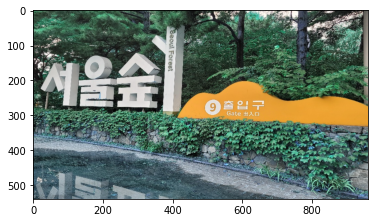

In [11]:
import matplotlib.pyplot as plt

plt.imshow(tempdataset.__getitem__(0))

### 2. Train / Validation Split


In [12]:
# Train : Validation = 0.75 : 0.25 Split
train_len = int(len(all_img_path)*0.75)
Vali_len = int(len(all_img_path)*0.25)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [13]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', Vali_len)

train set 길이 :  542
vaildation set 길이 :  180


### 3. transform


In [14]:
train_transform = transforms.Compose([
                    transforms.ToPILImage(), #Numpy배열에서 PIL이미지로
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), #이미지 사이즈 변형
                    transforms.ToTensor(), #이미지 데이터를 tensor
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), #이미지 정규화
                    transforms.RandomRotation(30),
                    transforms.RandomHorizontalFlip()
                    ])

test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

### 4. Dataloader


In [15]:
# Get Dataloader

#CustomDataset class를 통하여 train dataset생성
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) 
#만든 train dataset를 DataLoader에 넣어 batch 만들기
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

#vaildation 에서도 적용
vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [16]:
train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches)
print('total valid imgs :',Vali_len, '/ total valid batches :', vali_batches)

total train imgs : 542 / total train batches : 46
total valid imgs : 180 / total valid batches : 16


# III. 모델링


### 1. 모델 구조 정의


In [17]:
import torch.optim as optim
from tqdm.auto import tqdm
import torch.nn as nn
from torchvision import models

resnet=models.resnet50(pretrained=True).to(device)
for param in resnet.parameters():
  param.requires_grad=False

in_features=resnet.fc.in_features

classifier=nn.Sequential(
    nn.Linear(in_features,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,10),
)

resnet.fc=classifier


criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=resnet.parameters(),lr=CFG['LEARNING_RATE'], momentum=CFG['MOMENTUM'])
scheduler=None

resnet.to(device)

c:\ProgramData\Anaconda3\envs\readvice\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\readvice\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to C:\Users\jinhee/.cache\torch\hub\checkpoints\vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

AttributeError: 'VGG' object has no attribute 'fc'

In [ ]:
from torchsummary import summary
summary(resnet,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
from tqdm import tqdm

def train(model, optimizer, train_loader, scheduler, device): 
    model.to(device)
    n = len(train_loader)
    best_acc = 0
    
    for epoch in range(1,CFG["EPOCHS"]+1): #에포크 설정
        model.train() #모델 학습
        running_loss = 0.0
            
        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device) #배치 데이터
            optimizer.zero_grad() #배치마다 optimizer 초기화
        
            # Data -> Model -> Output
            logit = model(img) #예측값 산출
            loss = criterion(logit, label) #손실함수 계산
            
            # 역전파
            loss.backward() #손실함수 기준 역전파 
            optimizer.step() #가중치 최적화
            running_loss += loss.item()
              
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))
        
        if scheduler is not None:
            scheduler.step()
            
        #Validation set 평가
        model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
        vali_loss = 0.0
        correct = 0
        with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
            for img, label in tqdm(iter(vali_loader)):
                img, label = img.to(device), label.to(device)

                logit = model(img)
                vali_loss += criterion(logit, label)
                pred = logit.argmax(dim=1, keepdim=True)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
                correct += pred.eq(label.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
        vali_acc = 100 * correct / len(vali_loader.dataset)
        print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset)))
        
        #베스트 모델 저장
        if best_acc < vali_acc:
            best_acc = vali_acc
            torch.save(model.state_dict(), './save/best_model4.pth') #이 디렉토리에 best_model.pth을 저장
            print('Model Saved.')

### 2. 모델 학습


In [ ]:
import torch.optim as optim # 최적화 알고리즘들이 포함힘

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = vgg19_bn.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

In [ ]:
train(vgg19_bn, optimizer, train_loader, scheduler, device)


100%|██████████| 46/46 [00:11<00:00,  4.18it/s]


[1] Train loss: 2.0028670638


100%|██████████| 16/16 [00:03<00:00,  4.29it/s]


Vail set: Loss: 1.9844, Accuracy: 41/181 ( 23%)

Model Saved.


100%|██████████| 46/46 [00:10<00:00,  4.39it/s]


[2] Train loss: 1.3811685728


100%|██████████| 16/16 [00:03<00:00,  4.77it/s]


Vail set: Loss: 1.3085, Accuracy: 93/181 ( 51%)

Model Saved.


100%|██████████| 46/46 [00:11<00:00,  4.17it/s]


[3] Train loss: 0.9033886337


100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


Vail set: Loss: 1.2946, Accuracy: 87/181 ( 48%)



100%|██████████| 46/46 [00:11<00:00,  4.02it/s]


[4] Train loss: 0.6027052723


100%|██████████| 16/16 [00:03<00:00,  5.25it/s]


Vail set: Loss: 1.3402, Accuracy: 75/181 ( 41%)



100%|██████████| 46/46 [00:10<00:00,  4.36it/s]


[5] Train loss: 0.4840876803


100%|██████████| 16/16 [00:03<00:00,  5.07it/s]


Vail set: Loss: 1.3057, Accuracy: 78/181 ( 43%)



100%|██████████| 46/46 [00:11<00:00,  4.03it/s]


[6] Train loss: 0.4285481946


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Vail set: Loss: 1.6690, Accuracy: 74/181 ( 41%)



100%|██████████| 46/46 [00:11<00:00,  4.12it/s]


[7] Train loss: 0.4266992534


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Vail set: Loss: 1.3492, Accuracy: 97/181 ( 54%)

Model Saved.


100%|██████████| 46/46 [00:11<00:00,  4.03it/s]


[8] Train loss: 0.3919279217


100%|██████████| 16/16 [00:02<00:00,  5.38it/s]


Vail set: Loss: 1.1583, Accuracy: 98/181 ( 54%)

Model Saved.


100%|██████████| 46/46 [00:11<00:00,  4.00it/s]


[9] Train loss: 0.2586633453


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Vail set: Loss: 0.3525, Accuracy: 162/181 ( 90%)

Model Saved.


100%|██████████| 46/46 [00:11<00:00,  4.08it/s]


[10] Train loss: 0.2453227552


100%|██████████| 16/16 [00:02<00:00,  5.37it/s]


Vail set: Loss: 0.9841, Accuracy: 121/181 ( 67%)



100%|██████████| 46/46 [00:11<00:00,  4.08it/s]


[11] Train loss: 0.3030893671


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]


Vail set: Loss: 1.8687, Accuracy: 86/181 ( 48%)



100%|██████████| 46/46 [00:11<00:00,  4.17it/s]


[12] Train loss: 0.3146331825


100%|██████████| 16/16 [00:03<00:00,  4.19it/s]


Vail set: Loss: 0.3982, Accuracy: 154/181 ( 85%)



100%|██████████| 46/46 [00:10<00:00,  4.22it/s]


[13] Train loss: 0.2386469295


100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


Vail set: Loss: 0.5177, Accuracy: 149/181 ( 82%)



100%|██████████| 46/46 [00:11<00:00,  4.07it/s]


[14] Train loss: 0.2829377980


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Vail set: Loss: 1.5193, Accuracy: 102/181 ( 56%)



100%|██████████| 46/46 [00:11<00:00,  4.01it/s]


[15] Train loss: 0.2673495309


100%|██████████| 16/16 [00:02<00:00,  5.48it/s]


Vail set: Loss: 0.3699, Accuracy: 157/181 ( 87%)



100%|██████████| 46/46 [00:11<00:00,  4.06it/s]


[16] Train loss: 0.1736553843


100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


Vail set: Loss: 0.2786, Accuracy: 160/181 ( 88%)



100%|██████████| 46/46 [00:11<00:00,  4.17it/s]


[17] Train loss: 0.2186776455


100%|██████████| 16/16 [00:03<00:00,  4.16it/s]


Vail set: Loss: 5.3148, Accuracy: 21/181 ( 12%)



100%|██████████| 46/46 [00:10<00:00,  4.31it/s]


[18] Train loss: 0.3393017921


100%|██████████| 16/16 [00:03<00:00,  4.48it/s]


Vail set: Loss: 0.2263, Accuracy: 170/181 ( 94%)

Model Saved.


100%|██████████| 46/46 [00:10<00:00,  4.22it/s]


[19] Train loss: 0.1557951324


100%|██████████| 16/16 [00:03<00:00,  4.45it/s]


Vail set: Loss: 0.2804, Accuracy: 164/181 ( 91%)



100%|██████████| 46/46 [00:11<00:00,  4.17it/s]


[20] Train loss: 0.2235989682


100%|██████████| 16/16 [00:03<00:00,  4.75it/s]


Vail set: Loss: 0.3050, Accuracy: 160/181 ( 88%)



100%|██████████| 46/46 [00:11<00:00,  4.14it/s]


[21] Train loss: 0.1449270418


100%|██████████| 16/16 [00:02<00:00,  5.52it/s]


Vail set: Loss: 0.2907, Accuracy: 165/181 ( 91%)



100%|██████████| 46/46 [00:11<00:00,  4.02it/s]


[22] Train loss: 0.1377883063


100%|██████████| 16/16 [00:03<00:00,  5.27it/s]


Vail set: Loss: 0.4663, Accuracy: 154/181 ( 85%)



100%|██████████| 46/46 [00:11<00:00,  4.04it/s]


[23] Train loss: 0.1740919431


100%|██████████| 16/16 [00:03<00:00,  5.24it/s]


Vail set: Loss: 1.5618, Accuracy: 118/181 ( 65%)



100%|██████████| 46/46 [00:11<00:00,  4.13it/s]


[24] Train loss: 0.2514218100


100%|██████████| 16/16 [00:02<00:00,  5.49it/s]


Vail set: Loss: 1.3985, Accuracy: 118/181 ( 65%)



100%|██████████| 46/46 [00:10<00:00,  4.27it/s]


[25] Train loss: 0.3263854024


100%|██████████| 16/16 [00:03<00:00,  4.31it/s]


Vail set: Loss: 2.5644, Accuracy: 83/181 ( 46%)



100%|██████████| 46/46 [00:10<00:00,  4.35it/s]


[26] Train loss: 0.2622734456


100%|██████████| 16/16 [00:03<00:00,  4.88it/s]


Vail set: Loss: 0.2401, Accuracy: 165/181 ( 91%)



100%|██████████| 46/46 [00:10<00:00,  4.28it/s]


[27] Train loss: 0.1312484957


100%|██████████| 16/16 [00:03<00:00,  5.26it/s]


Vail set: Loss: 0.2984, Accuracy: 163/181 ( 90%)



100%|██████████| 46/46 [00:11<00:00,  4.07it/s]


[28] Train loss: 0.1266759411


100%|██████████| 16/16 [00:02<00:00,  5.40it/s]


Vail set: Loss: 1.0174, Accuracy: 122/181 ( 67%)



100%|██████████| 46/46 [00:11<00:00,  4.12it/s]


[29] Train loss: 0.2032383455


100%|██████████| 16/16 [00:03<00:00,  4.84it/s]


Vail set: Loss: 0.4506, Accuracy: 155/181 ( 86%)



100%|██████████| 46/46 [00:11<00:00,  4.14it/s]


[30] Train loss: 0.1994039843


100%|██████████| 16/16 [00:03<00:00,  4.78it/s]


Vail set: Loss: 1.4363, Accuracy: 115/181 ( 64%)



100%|██████████| 46/46 [00:10<00:00,  4.23it/s]


[31] Train loss: 0.2346457890


100%|██████████| 16/16 [00:03<00:00,  4.67it/s]


Vail set: Loss: 2.1427, Accuracy: 81/181 ( 45%)



100%|██████████| 46/46 [00:11<00:00,  4.16it/s]


[32] Train loss: 0.2133694780


100%|██████████| 16/16 [00:03<00:00,  4.86it/s]


Vail set: Loss: 1.2758, Accuracy: 111/181 ( 61%)



100%|██████████| 46/46 [00:11<00:00,  4.03it/s]


[33] Train loss: 0.1816287990


100%|██████████| 16/16 [00:03<00:00,  5.29it/s]


Vail set: Loss: 0.7664, Accuracy: 137/181 ( 76%)



100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


[34] Train loss: 0.2060574463


100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


Vail set: Loss: 1.2479, Accuracy: 130/181 ( 72%)



100%|██████████| 46/46 [00:11<00:00,  4.14it/s]


[35] Train loss: 0.1466078561


100%|██████████| 16/16 [00:03<00:00,  4.41it/s]


Vail set: Loss: 0.1632, Accuracy: 172/181 ( 95%)

Model Saved.


100%|██████████| 46/46 [00:11<00:00,  4.06it/s]


[36] Train loss: 0.1308779709


100%|██████████| 16/16 [00:03<00:00,  5.32it/s]


Vail set: Loss: 0.9906, Accuracy: 131/181 ( 72%)



100%|██████████| 46/46 [00:11<00:00,  4.10it/s]


[37] Train loss: 0.1423763232


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Vail set: Loss: 0.2821, Accuracy: 165/181 ( 91%)



100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


[38] Train loss: 0.1426346604


100%|██████████| 16/16 [00:02<00:00,  5.43it/s]


Vail set: Loss: 0.3898, Accuracy: 151/181 ( 83%)



100%|██████████| 46/46 [00:11<00:00,  4.09it/s]


[39] Train loss: 0.1393754868


100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


Vail set: Loss: 0.4642, Accuracy: 154/181 ( 85%)



100%|██████████| 46/46 [00:10<00:00,  4.20it/s]


[40] Train loss: 0.1598199591


100%|██████████| 16/16 [00:03<00:00,  4.31it/s]


Vail set: Loss: 0.5403, Accuracy: 151/181 ( 83%)



100%|██████████| 46/46 [00:10<00:00,  4.24it/s]


[41] Train loss: 0.1958817143


100%|██████████| 16/16 [00:03<00:00,  4.33it/s]


Vail set: Loss: 0.1397, Accuracy: 171/181 ( 94%)



100%|██████████| 46/46 [00:11<00:00,  4.16it/s]


[42] Train loss: 0.0863006113


100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Vail set: Loss: 0.1576, Accuracy: 173/181 ( 96%)

Model Saved.


100%|██████████| 46/46 [00:11<00:00,  4.08it/s]


[43] Train loss: 0.1057107735


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


Vail set: Loss: 0.1425, Accuracy: 176/181 ( 97%)

Model Saved.


100%|██████████| 46/46 [00:11<00:00,  4.02it/s]


[44] Train loss: 0.1084515008


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Vail set: Loss: 0.2233, Accuracy: 165/181 ( 91%)



100%|██████████| 46/46 [00:10<00:00,  4.24it/s]


[45] Train loss: 0.1298765869


100%|██████████| 16/16 [00:03<00:00,  4.73it/s]


Vail set: Loss: 0.2830, Accuracy: 164/181 ( 91%)



100%|██████████| 46/46 [00:11<00:00,  4.10it/s]


[46] Train loss: 0.2541207798


100%|██████████| 16/16 [00:03<00:00,  5.03it/s]


Vail set: Loss: 4.0367, Accuracy: 46/181 ( 25%)



100%|██████████| 46/46 [00:11<00:00,  4.14it/s]


[47] Train loss: 0.2385115935


100%|██████████| 16/16 [00:03<00:00,  4.29it/s]


Vail set: Loss: 0.2091, Accuracy: 168/181 ( 93%)



100%|██████████| 46/46 [00:13<00:00,  3.43it/s]


[48] Train loss: 0.1331176640


100%|██████████| 16/16 [00:03<00:00,  4.58it/s]


Vail set: Loss: 1.6508, Accuracy: 104/181 ( 57%)



100%|██████████| 46/46 [00:11<00:00,  4.10it/s]


[49] Train loss: 0.1909778872


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Vail set: Loss: 0.6522, Accuracy: 141/181 ( 78%)



100%|██████████| 46/46 [00:11<00:00,  4.00it/s]


[50] Train loss: 0.1423923625


100%|██████████| 16/16 [00:02<00:00,  5.51it/s]


Vail set: Loss: 0.2057, Accuracy: 168/181 ( 93%)



100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


[51] Train loss: 0.1318934261


100%|██████████| 16/16 [00:02<00:00,  5.46it/s]


Vail set: Loss: 0.3122, Accuracy: 164/181 ( 91%)



100%|██████████| 46/46 [00:11<00:00,  4.07it/s]


[52] Train loss: 0.1065744823


100%|██████████| 16/16 [00:03<00:00,  4.79it/s]


Vail set: Loss: 0.2368, Accuracy: 167/181 ( 92%)



100%|██████████| 46/46 [00:11<00:00,  4.12it/s]


[53] Train loss: 0.1217539551


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Vail set: Loss: 0.1515, Accuracy: 174/181 ( 96%)



100%|██████████| 46/46 [00:10<00:00,  4.20it/s]


[54] Train loss: 0.1171639995


100%|██████████| 16/16 [00:03<00:00,  4.43it/s]


Vail set: Loss: 0.5305, Accuracy: 154/181 ( 85%)



100%|██████████| 46/46 [00:10<00:00,  4.32it/s]


[55] Train loss: 0.1543924350


100%|██████████| 16/16 [00:03<00:00,  4.81it/s]


Vail set: Loss: 0.1671, Accuracy: 172/181 ( 95%)



100%|██████████| 46/46 [00:11<00:00,  4.13it/s]


[56] Train loss: 0.0900919189


100%|██████████| 16/16 [00:02<00:00,  5.47it/s]


Vail set: Loss: 0.1880, Accuracy: 171/181 ( 94%)



100%|██████████| 46/46 [00:11<00:00,  4.06it/s]


[57] Train loss: 0.1137142711


100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Vail set: Loss: 0.7699, Accuracy: 141/181 ( 78%)



100%|██████████| 46/46 [00:11<00:00,  4.07it/s]


[58] Train loss: 0.1785023257


100%|██████████| 16/16 [00:03<00:00,  4.81it/s]


Vail set: Loss: 0.3028, Accuracy: 165/181 ( 91%)



100%|██████████| 46/46 [00:11<00:00,  4.11it/s]


[59] Train loss: 0.1289688751


100%|██████████| 16/16 [00:03<00:00,  4.37it/s]


Vail set: Loss: 0.6930, Accuracy: 147/181 ( 81%)



100%|██████████| 46/46 [00:10<00:00,  4.27it/s]


[60] Train loss: 0.1853455979


100%|██████████| 16/16 [00:03<00:00,  4.68it/s]


Vail set: Loss: 1.7061, Accuracy: 102/181 ( 56%)



100%|██████████| 46/46 [00:10<00:00,  4.18it/s]


[61] Train loss: 0.1590497883


100%|██████████| 16/16 [00:03<00:00,  4.72it/s]


Vail set: Loss: 0.1260, Accuracy: 172/181 ( 95%)



100%|██████████| 46/46 [00:11<00:00,  4.14it/s]


[62] Train loss: 0.0838644242


100%|██████████| 16/16 [00:03<00:00,  4.73it/s]


Vail set: Loss: 0.1449, Accuracy: 174/181 ( 96%)



100%|██████████| 46/46 [00:10<00:00,  4.22it/s]


[63] Train loss: 0.1011094707


100%|██████████| 16/16 [00:03<00:00,  4.85it/s]


Vail set: Loss: 0.8057, Accuracy: 150/181 ( 83%)



100%|██████████| 46/46 [00:11<00:00,  4.18it/s]


[64] Train loss: 0.1656818722


100%|██████████| 16/16 [00:03<00:00,  5.04it/s]


Vail set: Loss: 0.4033, Accuracy: 163/181 ( 90%)



100%|██████████| 46/46 [00:11<00:00,  4.04it/s]


[65] Train loss: 0.1395560541


100%|██████████| 16/16 [00:02<00:00,  5.40it/s]


Vail set: Loss: 0.6034, Accuracy: 152/181 ( 84%)



100%|██████████| 46/46 [00:11<00:00,  4.16it/s]


[66] Train loss: 0.1439955980


100%|██████████| 16/16 [00:03<00:00,  4.38it/s]


Vail set: Loss: 0.1710, Accuracy: 170/181 ( 94%)



100%|██████████| 46/46 [00:10<00:00,  4.20it/s]


[67] Train loss: 0.0734574361


100%|██████████| 16/16 [00:03<00:00,  4.34it/s]


Vail set: Loss: 0.1466, Accuracy: 173/181 ( 96%)



100%|██████████| 46/46 [00:10<00:00,  4.31it/s]


[68] Train loss: 0.1466677349


100%|██████████| 16/16 [00:03<00:00,  4.68it/s]


Vail set: Loss: 0.6889, Accuracy: 143/181 ( 79%)



100%|██████████| 46/46 [00:11<00:00,  4.12it/s]


[69] Train loss: 0.2236793699


100%|██████████| 16/16 [00:03<00:00,  4.70it/s]


Vail set: Loss: 4.2296, Accuracy: 58/181 ( 32%)



100%|██████████| 46/46 [00:10<00:00,  4.23it/s]


[70] Train loss: 0.2431203548


100%|██████████| 16/16 [00:03<00:00,  4.74it/s]


Vail set: Loss: 0.6044, Accuracy: 150/181 ( 83%)



100%|██████████| 46/46 [00:10<00:00,  4.20it/s]


[71] Train loss: 0.1327202633


100%|██████████| 16/16 [00:03<00:00,  4.40it/s]


Vail set: Loss: 0.3832, Accuracy: 153/181 ( 85%)



100%|██████████| 46/46 [00:10<00:00,  4.23it/s]


[72] Train loss: 0.0882664640


100%|██████████| 16/16 [00:03<00:00,  4.79it/s]


Vail set: Loss: 0.1292, Accuracy: 174/181 ( 96%)



100%|██████████| 46/46 [00:11<00:00,  4.07it/s]


[73] Train loss: 0.0780603848


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]


Vail set: Loss: 0.2580, Accuracy: 164/181 ( 91%)



100%|██████████| 46/46 [00:11<00:00,  4.06it/s]


[74] Train loss: 0.1466471346


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Vail set: Loss: 1.1632, Accuracy: 124/181 ( 69%)



100%|██████████| 46/46 [00:11<00:00,  4.13it/s]


[75] Train loss: 0.1653039572


100%|██████████| 16/16 [00:03<00:00,  4.64it/s]


Vail set: Loss: 0.8975, Accuracy: 139/181 ( 77%)



100%|██████████| 46/46 [00:11<00:00,  4.18it/s]


[76] Train loss: 0.1582886450


100%|██████████| 16/16 [00:03<00:00,  4.34it/s]


Vail set: Loss: 0.3733, Accuracy: 157/181 ( 87%)



100%|██████████| 46/46 [00:10<00:00,  4.27it/s]


[77] Train loss: 0.1048166904


100%|██████████| 16/16 [00:03<00:00,  4.76it/s]


Vail set: Loss: 0.1452, Accuracy: 176/181 ( 97%)



100%|██████████| 46/46 [00:11<00:00,  4.14it/s]


[78] Train loss: 0.0533581049


100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


Vail set: Loss: 0.1711, Accuracy: 172/181 ( 95%)



100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


[79] Train loss: 0.0999579398


100%|██████████| 16/16 [00:03<00:00,  5.27it/s]


Vail set: Loss: 0.2031, Accuracy: 170/181 ( 94%)



100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


[80] Train loss: 0.1284002539


100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


Vail set: Loss: 1.1292, Accuracy: 123/181 ( 68%)



100%|██████████| 46/46 [00:11<00:00,  4.09it/s]


[81] Train loss: 0.1889514734


100%|██████████| 16/16 [00:03<00:00,  4.64it/s]


Vail set: Loss: 0.6140, Accuracy: 139/181 ( 77%)



100%|██████████| 46/46 [00:11<00:00,  4.18it/s]


[82] Train loss: 0.1172712294


100%|██████████| 16/16 [00:03<00:00,  4.62it/s]


Vail set: Loss: 0.1988, Accuracy: 170/181 ( 94%)



100%|██████████| 46/46 [00:11<00:00,  4.15it/s]


[83] Train loss: 0.1061733635


100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


Vail set: Loss: 0.4243, Accuracy: 153/181 ( 85%)



100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


[84] Train loss: 0.0956435811


100%|██████████| 16/16 [00:03<00:00,  5.24it/s]


Vail set: Loss: 0.1607, Accuracy: 170/181 ( 94%)



100%|██████████| 46/46 [00:11<00:00,  4.04it/s]


[85] Train loss: 0.0843565358


100%|██████████| 16/16 [00:02<00:00,  5.45it/s]


Vail set: Loss: 0.1733, Accuracy: 171/181 ( 94%)



100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


[86] Train loss: 0.0648344635


100%|██████████| 16/16 [00:03<00:00,  5.28it/s]


Vail set: Loss: 0.5553, Accuracy: 155/181 ( 86%)



100%|██████████| 46/46 [00:11<00:00,  4.03it/s]


[87] Train loss: 0.1126195155


100%|██████████| 16/16 [00:03<00:00,  4.80it/s]


Vail set: Loss: 0.3094, Accuracy: 161/181 ( 89%)



100%|██████████| 46/46 [00:11<00:00,  4.14it/s]


[88] Train loss: 0.0879046592


100%|██████████| 16/16 [00:03<00:00,  4.57it/s]


Vail set: Loss: 0.1829, Accuracy: 170/181 ( 94%)



100%|██████████| 46/46 [00:10<00:00,  4.19it/s]


[89] Train loss: 0.0991153677


100%|██████████| 16/16 [00:03<00:00,  4.78it/s]


Vail set: Loss: 1.1381, Accuracy: 126/181 ( 70%)



100%|██████████| 46/46 [00:12<00:00,  3.72it/s]


[90] Train loss: 0.1276605980


100%|██████████| 16/16 [00:04<00:00,  3.86it/s]


Vail set: Loss: 0.2175, Accuracy: 171/181 ( 94%)



100%|██████████| 46/46 [00:12<00:00,  3.70it/s]


[91] Train loss: 0.1315180157


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Vail set: Loss: 1.6612, Accuracy: 98/181 ( 54%)



100%|██████████| 46/46 [00:11<00:00,  4.14it/s]


[92] Train loss: 0.1628824172


100%|██████████| 16/16 [00:03<00:00,  4.57it/s]


Vail set: Loss: 0.3663, Accuracy: 165/181 ( 91%)



100%|██████████| 46/46 [00:11<00:00,  4.11it/s]


[93] Train loss: 0.0765923239


100%|██████████| 16/16 [00:03<00:00,  4.40it/s]


Vail set: Loss: 0.1189, Accuracy: 174/181 ( 96%)



100%|██████████| 46/46 [00:10<00:00,  4.23it/s]


[94] Train loss: 0.1348081404


100%|██████████| 16/16 [00:03<00:00,  4.28it/s]


Vail set: Loss: 6.5813, Accuracy: 36/181 ( 20%)



100%|██████████| 46/46 [00:10<00:00,  4.25it/s]


[95] Train loss: 0.2195381056


100%|██████████| 16/16 [00:03<00:00,  4.41it/s]


Vail set: Loss: 0.5182, Accuracy: 158/181 ( 87%)



100%|██████████| 46/46 [00:10<00:00,  4.26it/s]


[96] Train loss: 0.1168768498


100%|██████████| 16/16 [00:03<00:00,  4.32it/s]


Vail set: Loss: 0.1538, Accuracy: 175/181 ( 97%)



100%|██████████| 46/46 [00:10<00:00,  4.24it/s]


[97] Train loss: 0.1090397327


100%|██████████| 16/16 [00:03<00:00,  4.74it/s]


Vail set: Loss: 0.7992, Accuracy: 141/181 ( 78%)



100%|██████████| 46/46 [00:11<00:00,  4.14it/s]


[98] Train loss: 0.0871916442


100%|██████████| 16/16 [00:03<00:00,  5.07it/s]


Vail set: Loss: 0.4644, Accuracy: 156/181 ( 86%)



100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


[99] Train loss: 0.0922067478


100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


Vail set: Loss: 0.2250, Accuracy: 173/181 ( 96%)



100%|██████████| 46/46 [00:11<00:00,  4.08it/s]


[100] Train loss: 0.0898731516


100%|██████████| 16/16 [00:03<00:00,  4.48it/s]


Vail set: Loss: 0.1165, Accuracy: 178/181 ( 98%)

Model Saved.


### 3. 추론하기


In [ ]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [ ]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('./save/best_model4.pth')
resnet.load_state_dict(checkpoint)

# Inference
preds = predict(resnet, test_loader, device)
preds[0:5]

100%|██████████| 17/17 [00:04<00:00,  3.71it/s]


[7, 1, 9, 0, 6]

# IV. 데이콘 제출하기


### 1. submission 파일 생성


In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['label'] = preds

In [ ]:
submission.to_csv('./save/submission4.csv', index=False)